<font size="+4"><strong> Predicting Apartment Price</strong></font>

In [36]:
import warnings
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split

warnings.simplefilter(action="ignore", category=FutureWarning)

For this project, I am going to try to use the price, lat, lon & neighborhood features in this dataset to improve a regression model.

# Prepare Data

## Import

In [2]:
df = pd.read_csv("properati-real-estate-listings-mexico/data/properati_mx_2016_11_01_properties_sell.csv", encoding = 'utf8')

In [3]:
# Create State and neighborhood columns
df["state"] = df["place_with_parent_names"].str.split("|",expand =True)[2]
df["neighborhood"] = df["place_with_parent_names"].str.split("|",expand =True)[3]

#drop 'place_with_parent_names' column
df.drop(columns = "place_with_parent_names", inplace = True)

In [4]:
df.head(2)

,created_on,operation,property_type,place_name,geonames_id,lat_lon,lat,lon,price,currency,...,floor,rooms,expenses,properati_url,description,title,image_thumbnail,location,state,neighborhood
0,2013-09-19,sell,apartment,Nuevo Centro Urbano,NaN,POINT(-87.076686 20.627527),20.627527,-87.076686,269000.0,USD,...,NaN,NaN,NaN,http://nuevo-centro-urbano.properati.com.mx/o6...,Referencia #28010. En el centro de Playa del C...,Departamento en Venta. Ref. #28010. 3 Dormitor...,https://thumbs-cf.properati.com/3/q4Ws9xQT8Yu3...,POINT(-87.076686 20.627527),Quintana Roo,Solidaridad
1,2013-09-19,sell,apartment,Nuevo Centro Urbano,NaN,POINT(-87.076718 20.627567),20.627567,-87.076718,230000.0,USD,...,NaN,NaN,NaN,http://nuevo-centro-urbano.properati.com.mx/o8...,Referencia #28925. En el centro de Playa del C...,Departamento en Venta. Ref. #28925. 3 Dormitor...,https://thumbs-cf.properati.com/8/7W4OI5hIXPdY...,POINT(-87.076718 20.627567),Quintana Roo,Solidaridad


In [5]:
# subset state to Distrito Federal
df = df[df["state"] == 'Distrito Federal']

In [6]:
# Replace "" with NaN's
df["neighborhood"] = df["neighborhood"].apply(lambda x:"NaN" if x == "" else x)

In [7]:
# Subset apartment
prop_type = df["property_type"].unique()[0]
df = df[df["property_type"] == prop_type]


In [8]:
# subset price to $400,000.00
df = df[df["price_aprox_usd"] < 400_000]

In [9]:
#Handle outlier: clip lower and higher quantile
low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
df = df[df["surface_covered_in_m2"].between(low, high)]

## Explore

a point to consider is when trying to use multiple features in df alot of columns contain **missing values**. While missing values can be imputed, there still needs to be enough data in a column to do a good imputation. A general rule is that, if more than half of the data in a column is missing, it's better to drop it than try imputing. 

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11199 entries, 74 to 150913
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   created_on                  11199 non-null  object 
 1   operation                   11199 non-null  object 
 2   property_type               11199 non-null  object 
 3   place_name                  11199 non-null  object 
 4   geonames_id                 0 non-null      float64
 5   lat_lon                     10487 non-null  object 
 6   lat                         10487 non-null  float64
 7   lon                         10487 non-null  float64
 8   price                       11199 non-null  float64
 9   currency                    11199 non-null  object 
 10  price_aprox_local_currency  11199 non-null  float64
 11  price_aprox_usd             11199 non-null  float64
 12  surface_total_in_m2         1774 non-null   float64
 13  surface_covered_in_m2       1

In [11]:
def flag_columns(df):
    """
    This function compiles a list of columns having less than 50% non null values 
    compared with a column with 100% non null values
    """
    index_column = df['operation'].count()
    flagged_columns = []
    for column in df.columns:
        non_null_count = df[column].count()
        percentage = non_null_count / index_column
        
        if percentage < 0.5:
            flagged_columns.append(column)
            
    return flagged_columns

In [12]:
columns_drop = flag_columns(df)

In [13]:
columns_drop

['geonames_id',
 'surface_total_in_m2',
 'price_usd_per_m2',
 'floor',
 'rooms',
 'expenses']

In [14]:
df.drop(columns = columns_drop, inplace = True)

The next thing to look out for are **low or high cardinality** in categorical columns. If there's only one category in a column or two, it won't provide any unique information to the model. At the other extreme, columns where nearly every row has its own category won't help the model in identifying useful trends in the data either.

In [15]:
def identify_cardinality(df):
    cols_list = []
    
    for col in df.columns:
        if df[col].dtype == "object":
            unique_values = df[col].unique()
            #low cardinality columns
            if len(unique_values) <= 2:
                cols_list.append(col)
            #high cardinality columns
            elif len(unique_values) == len(df[col]):
                cols_list.append(col)
    return cols_list

In [16]:
# These columns gives additional information about property
informative_cols = ["description","created_on","place_name","title","image_thumbnail","lat_lon","location"]

In [17]:
cardinality = identify_cardinality(df)
print(f"delete these columns with high and low cardinality: {cardinality}")

delete these columns with high and low cardinality: ['operation', 'property_type', 'currency', 'properati_url', 'state']


In [18]:
df.drop(columns = cardinality, inplace = True)

In [19]:
df.drop(columns = informative_cols, inplace = True)

Here, columns like **operation** have only one value in them, while every row in **properati_url** has a unique value. These are clear examples of high- and low-cardinality features that shouldn't be included in the model.

It is important to drop any columns that would constitute **leakage**, that is, features that were created using our target or that would give our model information that it won't have access to when it's deployed. 

In [20]:
#remove leaky columns that will influence the model, keep only price aprox usd
leaks = []
for i in df.columns:
    if "price" in i:
        leaks.append(i)
leaks.remove("price_aprox_usd")
print(leaks)

['price', 'price_aprox_local_currency', 'price_per_m2']


In [21]:
df.drop(columns = leaks, inplace = True)

In [22]:
df.head()

,lat,lon,price_aprox_usd,surface_covered_in_m2,neighborhood
74,19.415010,-99.175174,146154.51,61.0,Cuauhtémoc
98,19.456564,-99.191724,36267.97,65.0,Miguel Hidalgo
106,19.512787,-99.141393,75783.82,70.0,Gustavo A. Madero
110,19.362370,-99.143951,92023.21,70.0,Benito Juárez
113,19.246470,-99.101350,94459.12,74.0,Xochimilco


In [23]:
corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
corr

,lat,lon,surface_covered_in_m2
lat,1.000000,-0.938393,-0.018464
lon,-0.938393,1.000000,-0.020478
surface_covered_in_m2,-0.018464,-0.020478,1.000000


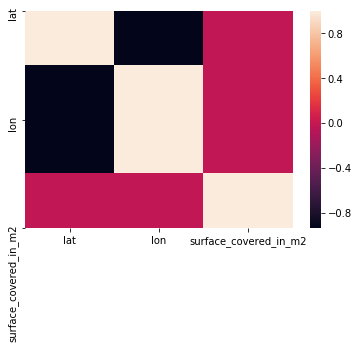

In [24]:
sns.heatmap(corr);

## Split Data

In [25]:
target = "price_aprox_usd"
feature = ['surface_covered_in_m2', 'lat', 'lon', 'neighborhood']


X = df[feature]
y = df[target]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

# Build Model

## Baseline

In [27]:
y_mean = y_train.mean()
print("Mean apt price:", y_mean.round(2))
y_pred_baseline = [y_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Baseline MAE:", mae_baseline.round(2))

Mean apt price: 103062.61
Baseline MAE: 58121.57


## Iterate

In [28]:
model = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    Ridge()
)


In [29]:
model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [30]:
model.score(X_test,y_test)

0.37003515702637335

## Evaluate

In [31]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train,y_pred_training))

Training MAE: 42716.28789325744


In [32]:
def make_prediction(area, lat, lon, neighborhood):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon":lon,
        "neighborhood": neighborhood
    }
    df = pd.DataFrame(data, index = [0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price is {prediction}"

In [33]:
make_prediction(55,19,-99,"Solidaridad")

'Predicted apartment price is 49612.59'

In [34]:
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    133414.268908
1    125808.187607
2    142552.519613
3     92655.809562
4     55417.626658
dtype: float64

# Communicate Results

In [35]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=76, description='area', max=127, min=50), FloatSlider(value=19.481224935…